In [1]:
#Importing Packages
import xarray as xr
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
import mpl_scatter_density
import numpy as np
import skgstat as skg
from sklearn import preprocessing

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from src.helper_functions import grid_coords_to_2d_latlon_coords
from src.helper_functions import create_mask

In [2]:
#Loading climate data
base_path = '/home/jez/Bias_Correction/'
nst_climate_path = f'{base_path}data/ProcessedData/MetUM_Reformatted.nc'
ele_climate_path = f'{base_path}data/Antarctic_CORDEX_MetUM_0p44deg_orog.nc'
mask_path = f'{base_path}data/ProcessedData/MetUM_044_Masks.nc'

ds_nst_climate = xr.open_dataset(nst_climate_path)
ds_ele_climate = xr.open_dataset(ele_climate_path)
ds_mask = xr.open_dataset(mask_path)

ds_climate = xr.merge([ds_nst_climate,ds_ele_climate,ds_mask])
ds_climate = ds_climate.isel(time=(ds_climate.time.dt.month == 1))
ds_climate['tas']=ds_climate['tas']-273.15

ds_climate['Mean Jan Temperature'] = ds_climate['tas'].mean(['time'])
ds_climate['Variance Jan Temperature'] = ds_climate['tas'].var(['time'])

ds_climate_stacked = ds_climate.stack(X=('grid_latitude', 'grid_longitude'))

obs_path = f'{base_path}data/ProcessedData/NST_Observations_Reformatted.nc'
ds_obs = xr.open_dataset(obs_path)

ds_obs_stacked = ds_obs.stack(D=('Year','Day'))
sorting_axis = ds_obs_stacked["Temperature()"].dims.index('D')
ds_obs_stacked["Temperature()"].data = np.sort(ds_obs_stacked["Temperature()"].data, axis=sorting_axis) # sorting Nans to back
ds_obs_stacked = ds_obs_stacked.dropna('D','all').dropna('Station_Lower','all')
min_days_data_condition = (ds_obs_stacked.isnull()==False).sum('D')>100
ds_obs_stacked = ds_obs_stacked.where(min_days_data_condition,drop=True)
ds_obs_stacked['non_null_values'] = (ds_obs_stacked['Temperature()'].isnull()==False).sum('D')

In [3]:
x1_train = ds_climate_stacked.orog.where(ds_climate_stacked.lsm,drop=True)
x2_train = ds_climate_stacked.latitude.where(ds_climate_stacked.lsm,drop=True)
Xtrain = np.dstack([x1_train,x2_train]).reshape(-1,2)
ytrain = ds_climate_stacked['Mean Jan Temperature'].where(ds_climate_stacked.lsm,drop=True)

model = LinearRegression()
poly_features = PolynomialFeatures(degree=2)#, include_bias=False)
Xtrain_poly = poly_features.fit_transform(Xtrain)
model.fit(Xtrain_poly, ytrain)

x1 = ds_climate_stacked.orog
x2 = ds_climate_stacked.latitude
X = np.dstack([x1,x2]).reshape(-1,2)
X_poly = poly_features.fit_transform(X)
y_pred = model.predict(X_poly)
ds_climate_stacked['Mean Jan Temperature Pred'] = (('X'), y_pred)
ds_climate_stacked['Mean Jan Temperature Residual'] = ds_climate_stacked['Mean Jan Temperature']-ds_climate_stacked['Mean Jan Temperature Pred']
ds_climate = ds_climate_stacked.unstack()

In [4]:
x1 = ds_obs_stacked['Elevation(m)']
x2 = ds_obs_stacked['Lat(°C)']
X = np.dstack([x1,x2]).reshape(-1,2)
X_poly = poly_features.fit_transform(X)
y_pred = model.predict(X_poly)
ds_obs_stacked['Temperature Pred'] = (('Station_Lower'), y_pred)
ds_obs_stacked['Temperature Residual'] = ds_obs_stacked['Temperature()'].mean('D')-ds_obs_stacked['Temperature Pred']

In [5]:
obs_grid_longitudes = ds_obs_stacked.isel(D=0).grid_longitude
obs_grid_latitudes = ds_obs_stacked.isel(D=0).grid_latitude
ds_climate_nearest = ds_climate.sel(grid_longitude=obs_grid_longitudes,grid_latitude=obs_grid_latitudes,method='nearest')
da_difference_residual = ds_climate_nearest['Mean Jan Temperature Residual'] - ds_obs_stacked['Temperature Residual']
ds_obs_stacked['Difference Nearest Residual'] = (('Station_Lower'), da_difference_residual.data)

In [6]:
rotated_coord_system = ccrs.RotatedGeodetic(
    13.079999923706055,
    0.5199999809265137,
    central_rotated_longitude=180.0,
    globe=None,
)
antarctica_shapefile_path = f'{base_path}data/Antarctica_Shapefile/antarctica_shapefile.shp'
antarctica_gdf = gpd.read_file(antarctica_shapefile_path)
antarctica_gdf = antarctica_gdf.to_crs(rotated_coord_system)

ERROR:fiona._env:PROJ: proj_identify: /home/jez/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


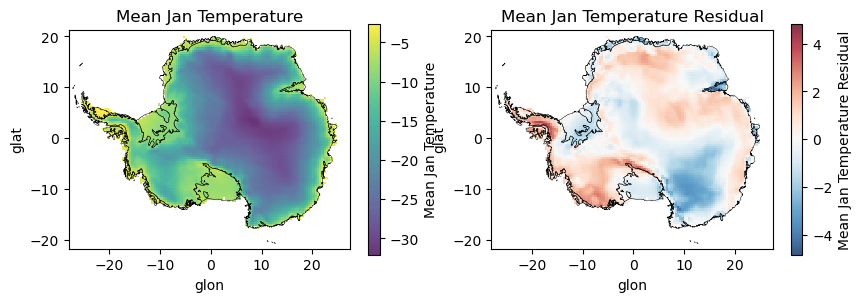

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
ds = ds_climate.where(ds_climate.lsm)
ds['Mean Jan Temperature'].plot.pcolormesh(
    x='glon',y='glat',ax=axs[0],alpha=0.8)
axs[0].set_title('Mean Jan Temperature')
ds['Mean Jan Temperature Residual'].plot.pcolormesh(
    x='glon',y='glat',ax=axs[1],alpha=0.8)
axs[1].set_title('Mean Jan Temperature Residual')
for ax in axs.ravel():
    antarctica_gdf.boundary.plot(ax=ax, color="k", linewidth=0.3)

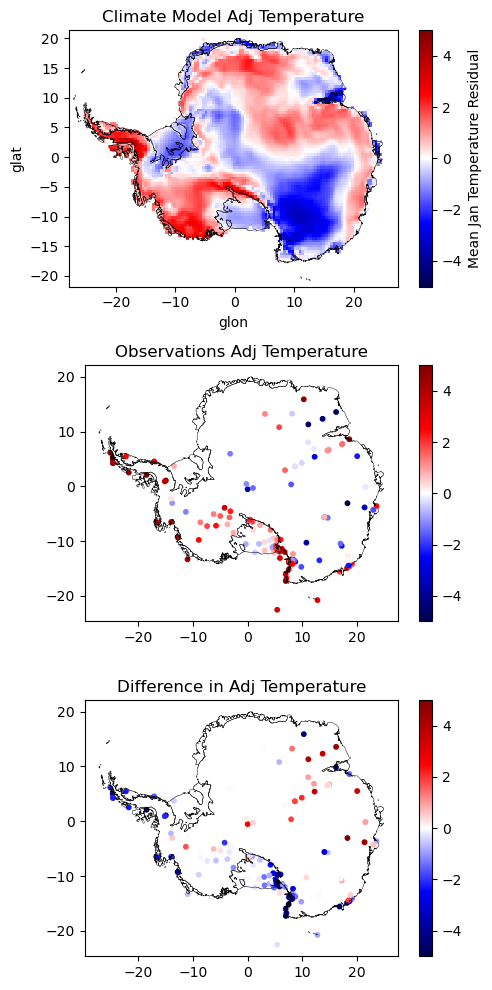

In [8]:
fig, axs = plt.subplots(3, 1, figsize=(5, 10))
s=10
vmin=-5
vmax=5
cmap = 'seismic'

da = ds_climate['Mean Jan Temperature Residual'].where(ds_climate.lsm)
da.plot.pcolormesh(x='glon',y='glat',ax=axs[0],vmin=vmin,vmax=vmax,cmap=cmap)

plots=[]
plots.append(axs[1].scatter(
    x=ds_obs_stacked.glon,y=ds_obs_stacked.glat,
    c=ds_obs_stacked['Temperature Residual'],
    vmin=vmin,vmax=vmax,cmap=cmap,
    s=s))
plots.append(axs[2].scatter(
    x=ds_obs_stacked.glon,y=ds_obs_stacked.glat,
    c=ds_obs_stacked['Difference Nearest Residual'],
    vmin=vmin,vmax=vmax,cmap=cmap,
    s=s))

for plot in plots:
    plt.colorbar(plot)
titles = ['Climate Model Adj Temperature',
          'Observations Adj Temperature',
          'Difference in Adj Temperature']
for ax,title in zip(axs.ravel(),titles):
    antarctica_gdf.boundary.plot(ax=ax, color="k", linewidth=0.3)
    ax.set_title(title)
plt.tight_layout()

/home/jez/anaconda3/envs/BC/lib/python3.9/site-packages/xarray/plot/plot.py:952: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  primitive = ax.scatter(*[v.to_numpy().ravel() for v in plts], **kwargs)
/home/jez/anaconda3/envs/BC/lib/python3.9/site-packages/xarray/plot/plot.py:952: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  primitive = ax.scatter(*[v.to_numpy().ravel() for v in plts], **kwargs)
/home/jez/anaconda3/envs/BC/lib/python3.9/site-packages/xarray/plot/plot.py:952: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  primitive = ax.scatter(*[v.to_numpy().ra

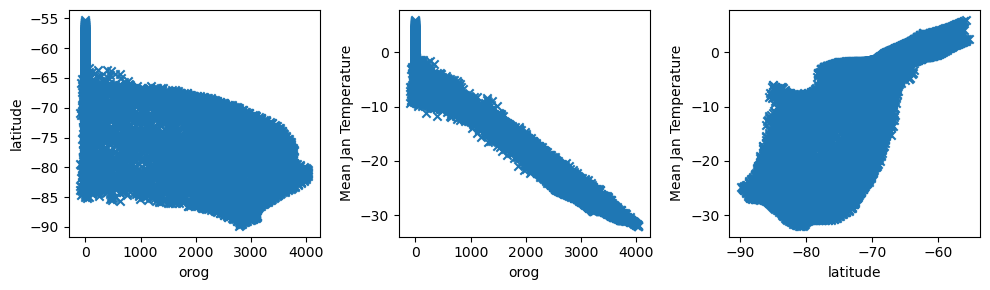

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
ds = ds_climate.where(ds_climate.lsm)
ds_climate_stacked.mean('time').plot.scatter(
    'orog','latitude',
    marker='x',ax=axs[0])
ds_climate_stacked.mean('time').plot.scatter(
    'orog','Mean Jan Temperature',
    marker='x',ax=axs[1])
ds_climate_stacked.mean('time').plot.scatter(
    'latitude','Mean Jan Temperature',
    marker='x',ax=axs[2])
titles =['','','']
for ax,title in zip(axs.ravel(),titles):
    ax.set_title(title)
plt.tight_layout()
plt.show()

/home/jez/anaconda3/envs/BC/lib/python3.9/site-packages/xarray/plot/plot.py:952: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  primitive = ax.scatter(*[v.to_numpy().ravel() for v in plts], **kwargs)


Text(0.5, 1.0, '')

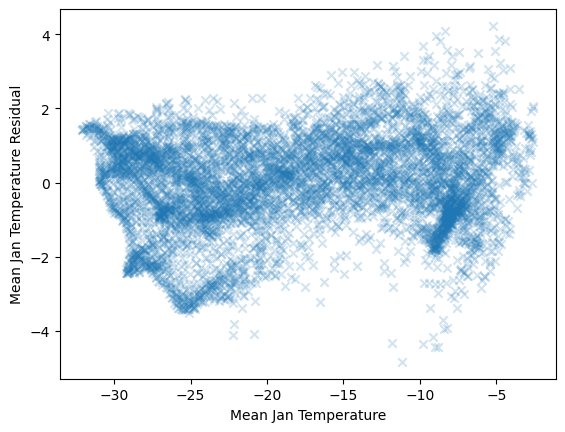

In [10]:
ds = ds_climate_stacked.mean('time').where(ds_climate_stacked.lsm)
ds.plot.scatter(
    'Mean Jan Temperature','Mean Jan Temperature Residual',hue=None,
    marker='x',alpha=0.2)
plt.title('')

In [11]:
cond1 = ds_climate_stacked['Mean Jan Temperature']>-9.2
cond2 = ds_climate_stacked['Mean Jan Temperature']<-7.3
cond3 = ds_climate_stacked['Mean Jan Temperature Residual']<-0.5
cond4 = ds_climate_stacked['Mean Jan Temperature Residual']>-2
indicator1 = cond1 & cond2 & cond3 & cond4

cond1 = ds_climate_stacked['Mean Jan Temperature']>-30
cond2 = ds_climate_stacked['Mean Jan Temperature']<-27.5
cond3 = ds_climate_stacked['Mean Jan Temperature Residual']<-1.8
cond4 = ds_climate_stacked['Mean Jan Temperature Residual']>-2.6
indicator2 = cond1 & cond2 & cond3 & cond4

cond1 = ds_climate_stacked['Mean Jan Temperature']>-31
cond2 = ds_climate_stacked['Mean Jan Temperature']<-27
cond3 = ds_climate_stacked['Mean Jan Temperature Residual']<1.4
cond4 = ds_climate_stacked['Mean Jan Temperature Residual']>0.3
indicator3 = cond1 & cond2 & cond3 & cond4

ds_climate_stacked['indicator1'] = indicator1
ds_climate_stacked['indicator2'] = indicator2
ds_climate_stacked['indicator3'] = indicator3
ds_climate=ds_climate_stacked.unstack()

/home/jez/anaconda3/envs/BC/lib/python3.9/site-packages/xarray/plot/plot.py:952: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  primitive = ax.scatter(*[v.to_numpy().ravel() for v in plts], **kwargs)


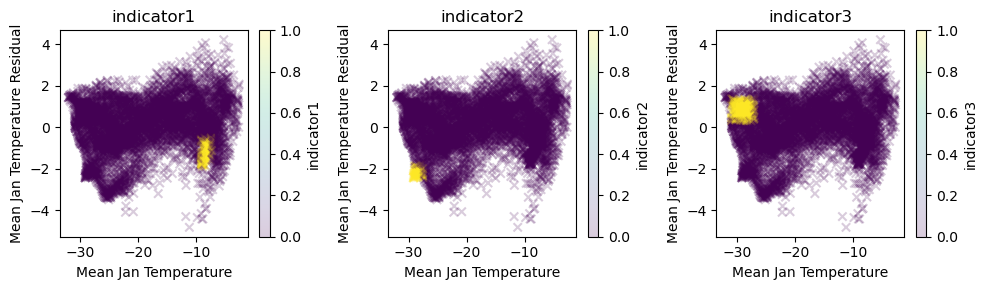

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

ds = ds_climate_stacked.mean('time').where(ds_climate_stacked.lsm)
vars = ['indicator1','indicator2','indicator3']

for ax,var in zip(axs,vars):
    ds.plot.scatter(
        'Mean Jan Temperature','Mean Jan Temperature Residual',hue=f'{var}',
        marker='x',alpha=0.2,ax=ax)
    ax.set_title(f'{var}')

plt.tight_layout()

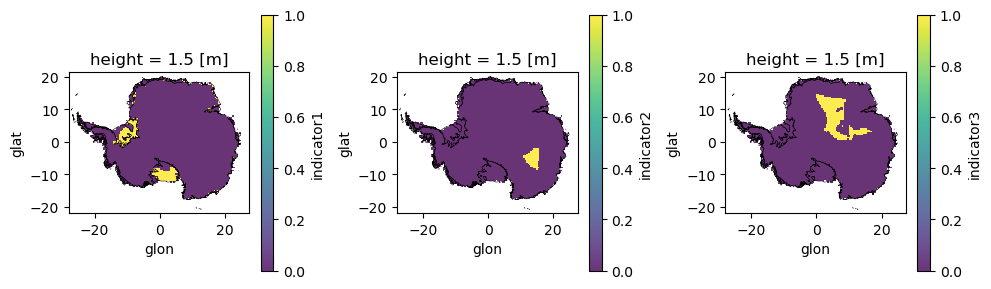

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

for ax,var in zip(axs,vars):
    da = ds_climate[f'{var}'].where(ds_climate.lsm)
    da.plot.pcolormesh(
        x='glon',y='glat',ax=ax,alpha=0.8)
    antarctica_gdf.boundary.plot(ax=ax, color="k", linewidth=0.3)
plt.tight_layout()

/home/jez/anaconda3/envs/BC/lib/python3.9/site-packages/xarray/plot/plot.py:952: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  primitive = ax.scatter(*[v.to_numpy().ravel() for v in plts], **kwargs)


Text(0.5, 1.0, 'Elevation')

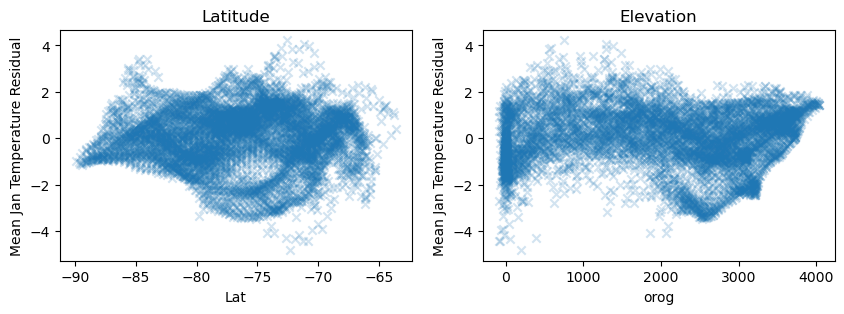

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

ds = ds_climate_stacked.mean('time').where(ds_climate_stacked.lsm)
ds['Lat'] = (('X'), ds_climate_stacked.latitude.data)

ds.plot.scatter(
    'Lat','Mean Jan Temperature Residual',
    marker='x',alpha=0.2,ax=axs[0])
axs[0].set_title('Latitude')
ds.plot.scatter(
    'orog','Mean Jan Temperature Residual',
    marker='x',alpha=0.2,ax=axs[1])
axs[1].set_title('Elevation')

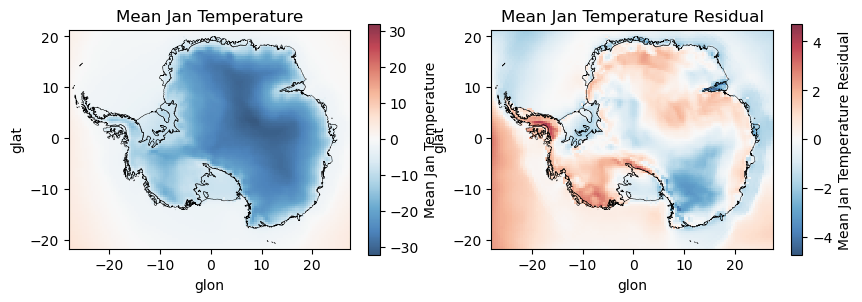

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
ds = ds_climate#.where(ds_climate.lsm)
ds['Mean Jan Temperature'].plot.pcolormesh(
    x='glon',y='glat',ax=axs[0],alpha=0.8)
axs[0].set_title('Mean Jan Temperature')
ds['Mean Jan Temperature Residual'].plot.pcolormesh(
    x='glon',y='glat',ax=axs[1],alpha=0.8)
axs[1].set_title('Mean Jan Temperature Residual')
for ax in axs.ravel():
    antarctica_gdf.boundary.plot(ax=ax, color="k", linewidth=0.3)